# Homework 1: Classification with Tabular Data

Cameron Wolff, see bottom for report

In [1]:
import numpy as np
import sklearn
import torch
import os

In [2]:
if not os.path.exists('tree_species_classifier_data.npz'):
  !wget -O tree_species_classifier_data.npz "https://www.dropbox.com/scl/fi/b7mw23k3ifaeui9m8nnn3/tree_species_classifier_data.npz?rlkey=bgxp37c1t04i7q35waf3slc26&dl=1"

In [3]:
data = np.load('tree_species_classifier_data.npz')
train_features = data['train_features']
train_labels = data['train_labels']
test_features = data['test_features']
test_labels = data['test_labels']

In [4]:
# Inspecting the data
train_labels

array([1, 1, 1, ..., 7, 7, 7], shape=(15707,), dtype=uint8)

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8)

In [6]:
train_features

array([[   0,  338,  252, ...,  113,  116,  152],
       [   0,  453,  339, ...,  120,  117,  150],
       [   0,  460,  378, ...,  122,  143,  155],
       ...,
       [   0,  785,  710, ...,  720,  715,  711],
       [   0,  838,  663, ...,  704,  649,  673],
       [   0, 1056,  761, ...,  790,  707,  776]],
      shape=(15707, 426), dtype=int16)

In [7]:
test_labels.shape, test_features.shape

((1554,), (1554, 426))

((array([ 81., 148.,  62.,   9.,   6.,  17.,  24.,  18.,  48.,  13.]),
  array([   0.,  181.,  362.,  543.,  724.,  905., 1086., 1267., 1448.,
         1629., 1810.]),
  <BarContainer object of 10 artists>),
 (array([  1.,  55., 138.,  40.,  56.,   6.,   9.,  25.,  49.,  47.]),
  array([   0. ,  369.6,  739.2, 1108.8, 1478.4, 1848. , 2217.6, 2587.2,
         2956.8, 3326.4, 3696. ]),
  <BarContainer object of 10 artists>))

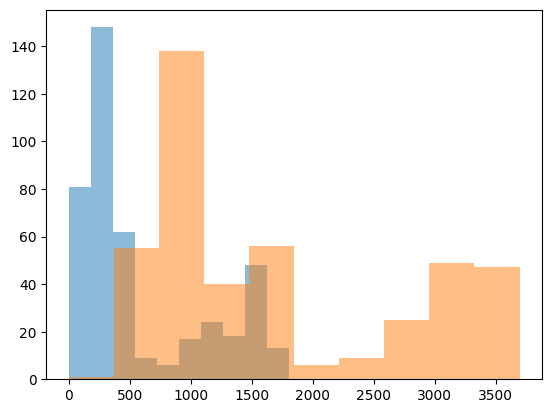

In [8]:
import matplotlib.pyplot as plt

plt.hist(train_features[0], alpha=0.5), plt.hist(train_features[len(train_features[0])-1], alpha=0.5)

In [10]:
# Pre-Processing
pca = sklearn.decomposition.PCA(n_components=32, whiten=True)

train_features_reduced = pca.fit_transform(train_features)
test_features_reduced = pca.transform(test_features)

In [11]:
# Classifiers using scikit-learn
sklearn_linear = sklearn.linear_model.LogisticRegression()
sklearn_linear.fit(train_features_reduced, train_labels)

sklearn_nn = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=(100,), activation='relu', max_iter=1_000)
sklearn_nn.fit(train_features_reduced, train_labels)

sklearn_linear_accuracy = sklearn.metrics.accuracy_score(
    sklearn_linear.predict(test_features_reduced), 
    test_labels)
sklearn_nn_accuracy = sklearn.metrics.accuracy_score(
    sklearn_nn.predict(test_features_reduced), 
    test_labels)

print(f'Linear Classifier accuracy: {sklearn_linear_accuracy}')
print(f'Neural Network Classifier accuracy: {sklearn_nn_accuracy}')

Linear Classifier accuracy: 0.833976833976834
Neural Network Classifier accuracy: 0.797940797940798


In [12]:
# Classifiers using PyTorch

# a. Create a TensorDataset and DataLoader with batch size 32, train using random shuffling
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(train_features_reduced, dtype=torch.float32), 
        torch.tensor(train_labels, dtype=torch.long)),
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(test_features_reduced, dtype=torch.float32), 
        torch.tensor(test_labels, dtype=torch.long)),
    batch_size=batch_size,
)

In [13]:
# calculates the accuracy of the model
def accuracy(model, dataloader: torch.utils.data.DataLoader):
    model.eval()  # Set the model to evaluation mode

    acc = None
    with torch.no_grad():  # Disable gradient calculation
        correct = 0
        total = 0
        for features_train, labels_train in iter(dataloader):        
            z = torch.argmax(model(features_train), dim=1)
            correct += (z == labels_train).float().sum()
            total += z.shape[0]
            
        acc = correct / total
    return acc

In [14]:
# trains the model
def train(model, dataloader: torch.utils.data.DataLoader):
    lr = 1e-2
    weight_decay = 0.001
    epochs = 100
    opt = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        opt.zero_grad() # zero out the gradients
    
        features_train, labels_train = next(iter(dataloader)) 

        z = model(features_train) # compute model outputs
        loss = loss_fn(z, labels_train) # compute loss
    
        loss.backward() # compute gradients
    
        opt.step() # apply gradients in optimizer step
        
        print(f'accuracy | train {accuracy(torch_linear, train_dataloader):.4f} | test {accuracy(torch_linear, test_dataloader):.4f}')

In [18]:
# train a linear classifier and a neural network
torch_linear = torch.nn.Linear(32, 8)

# 32 input layer, 100 hidden layer, 2 output layer
torch_nn = torch.nn.Sequential(
    torch.nn.Linear(32, 100),
    torch.nn.SiLU(), 
    torch.nn.Linear(100, 8),
    torch.nn.Sigmoid()
)

print('Linear Classifier')
train(torch_linear, train_dataloader)
print('\nNeural Network Classifier')
train(torch_nn, train_dataloader)


Linear Classifier
accuracy | train 0.1604 | test 0.1667
accuracy | train 0.1622 | test 0.1673
accuracy | train 0.1637 | test 0.1692
accuracy | train 0.1656 | test 0.1705
accuracy | train 0.1674 | test 0.1725
accuracy | train 0.1708 | test 0.1744
accuracy | train 0.1726 | test 0.1750
accuracy | train 0.1744 | test 0.1770
accuracy | train 0.1775 | test 0.1776
accuracy | train 0.1787 | test 0.1821
accuracy | train 0.1808 | test 0.1834
accuracy | train 0.1829 | test 0.1840
accuracy | train 0.1857 | test 0.1840
accuracy | train 0.1872 | test 0.1866
accuracy | train 0.1886 | test 0.1892
accuracy | train 0.1907 | test 0.1911
accuracy | train 0.1927 | test 0.1937
accuracy | train 0.1955 | test 0.1963
accuracy | train 0.1981 | test 0.1988
accuracy | train 0.2004 | test 0.2001
accuracy | train 0.2028 | test 0.2027
accuracy | train 0.2062 | test 0.2059
accuracy | train 0.2094 | test 0.2085
accuracy | train 0.2129 | test 0.2111
accuracy | train 0.2158 | test 0.2136
accuracy | train 0.2184 | test 0

# Report

### Code Explanation
To solve this problem, I used a conventional approach following the problem's description, sticking to the sklearn toolbox for the first section, then switching to PyTorch and custom written functions for the second. 

The dataset appeared to have 8 unique labels, so when creating the PyTorch models I specified an output layer of that size.

I used the sklearn and pytorch documentation to find specific function definitions. When I wanted more general syntax knowledge on API I was unframiliar with, or when I got stuck trying to determine layers not aligning when training my PyTorch models, I used the Quen2.5-Coder-14B LLM, pulled from hugging face. The model showed me example syntax for the functions, which I heavily tweaked to fit my code, and suggested I make sure my dataset only had 2 classes, which it did not. I chose a SiLu activation function for its improvements over ReLu for PyTorch, but this does not seem to have improved results. 

### Discussion
Training matrix was 15,707x426, test matrix was 1,554x426. The rows are the records or samples of the dataset, which each appears to represent a hyperspectral image of one tree. The columns, or features, appear to represent different spectrum, and range from around 0 to 3,000. There are 8 classes corresponding to the following tree species: White fir, Red fir, Incense cedar, Jeffrey pine, Sugar pine, Black oak, Lodgepole pine, and Dead trees. Classes are provided unevenly, with much more of classes 3 and 7, but classes are distrubuted evenly between training and test data.

Both pytorch models appear to not overfit the data, as the training and test accuracy is very low. The scikit learn results, with a higher 1,000 iterations, seem to have converged with a much higher accuracy. The linear model, surprisingly, has a higher accuracy than the more complex neural network.